In [1]:
from scipy.stats import expon
from scipy.stats import uniform
from scipy.stats import multinomial
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.linalg import sqrtm

In [2]:
def intensity(t,m,history,M,parameters):   #left continue    beta_12 is influence from 2 to 1
    mu=parameters[0][m]   #value
    alpha=parameters[1][m]   #vector
    beta=parameters[2][m]    #vector
    intensity=0
    for n in range(M):
        for i in range(len(history[n])):
            if history[n][i]>=t:
                break
            intensity+=alpha[n]*np.exp(-beta[n]*(t-history[n][i]))
    return mu+intensity

In [3]:
def multi_hawkes_simulation(mu,alpha,beta,M,T):
    assert len(mu)==len(alpha[0])==len(beta[0])==M
    t=0
    parameters=[mu,alpha,beta]
    jump=[0]*M
    points_hawkes=[]
    for i in range(M):
        points_hawkes.append([])
    while(t<T):
        intensity_sup=sum(intensity(t,m,points_hawkes,M,parameters)+jump[m] for m in range(M))
        r=expon.rvs(scale=1/intensity_sup) #scale=1/lamda
        t+=r
        D=uniform.rvs(loc=0,scale=1)
        if D*intensity_sup<=sum(intensity(t,m,points_hawkes,M,parameters) for m in range(M)):
            sum_intensity=sum(intensity(t,m,points_hawkes,M,parameters) for m in range(M))
            k=list(multinomial.rvs(1,[intensity(t,m,points_hawkes,M,parameters)/sum_intensity for m in range(M)])).index(1)
            points_hawkes[k].append(t)
            jump=np.array(alpha)[:,k]
        else:
            jump=[0]*M
    if points_hawkes[k][-1]>T:
        del points_hawkes[k][-1]
    return points_hawkes

In [136]:
T=500

In [137]:
M=2

In [138]:
mu=[0.5,0.5]
alpha=[[1,0.5],[0.5,1]]
beta=[[2,2],[2,2]]
parameters=[mu,alpha,beta]

In [139]:
points_hawkes=multi_hawkes_simulation(mu,alpha,beta,M,T)

In [140]:
len(points_hawkes[0]),len(points_hawkes[1])

(895, 928)

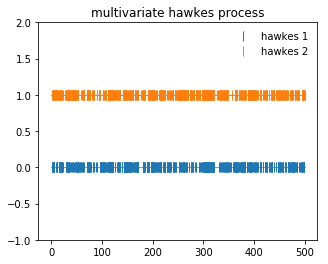

In [141]:
plt.figure(1,figsize=(5,4))               
plt.subplot(1,1,1)             # points position
for m in range(M):
    plt.plot([0,T],[m,m],'r-',lw=1,alpha=0.6)
    plt.plot(points_hawkes[m],[m]*len(points_hawkes[m]),linestyle='None', marker='|', markersize=10,label=('hawkes %s'%(m+1)))
plt.title('multivariate hawkes process')
plt.ylim(-1,2)
plt.legend(loc='best',frameon=0)
plt.show()

In [14]:
def negtiveloglikelyhood_multi(parameters, times, T, M):     #calculate -loglikelyhood for >=2D Hawkes
    mu=parameters[0]
    alpha=parameters[1]
    beta=parameters[2]
    
    timedifference=[[]]*M
    for m in range(M):
        times[m]=np.array(times[m])
        timedifference[m]=T-times[m] #T-t0...T-t(n-1)
    
    secondsum=[0]*M
    timeexponential=[[]]*M
    for m in range(M):
        for n in range(M):
            timeexponential[n]=np.exp(-beta[m][n]*timedifference[n])-1
        secondsum[m]=sum(alpha[m][n]/beta[m][n]*sum(timeexponential[n]) for n in range(M))
        
    firstsum=0
    for m in range(M):
        for t in times[m]:
            temp=intensity(t,m,times,M,parameters)
            if temp<0.00001: temp=0.00001
            firstsum+=np.log(temp)
    
    negtivelogl=0
    for m in range(M):
        negtivelogl+=-mu[m]*T+secondsum[m]
    negtivelogl=-(firstsum+negtivelogl)
    return negtivelogl

In [15]:
def negtiveloglikelyhood_multi_1(parameter_list, times, T, M): # all the parameters are in a 1-D list. mu_0 mu_1 alpha...beta...
    assert len(parameter_list)==M*M*2+M, 'Number of parameters and number of dimensions do not match.'
    
    mu=np.zeros((M,1))
    alpha=np.zeros((M,M))
    beta=np.zeros((M,M))
    for m in range(M):
        mu[m]=parameter_list[m]
        for n in range(M):
            alpha[m][n]=parameter_list[(m+1)*M+n]
            beta[m][n]=parameter_list[(m+M+1)*M+n]
    
    return negtiveloglikelyhood_multi([mu,alpha,beta], times, T, M)

In [16]:
init=[0.5,0.5,0.5,0.5,0.5,0.5,2,2,2,2]
res=optimize.minimize(negtiveloglikelyhood_multi_1, init, args=(points_hawkes,T,M), method='SLSQP', \
        bounds=((0,2),(0,2),(0,2),(0,2),(0,2),(0,2),(0.01,3),(0.01,3),(0.01,3),(0.01,3)), options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 64.86077030243598
            Iterations: 23
            Function evaluations: 291
            Gradient evaluations: 23


In [17]:
res.x

array([0.09140795, 0.56794802, 0.34687369, 0.93656264, 0.36599096,
       1.19962958, 0.60926453, 3.        , 1.336883  , 2.49344049])

## EM-Euler-Lagarangian

In [366]:
def multidimension_to_onedimension(points_hawkes):
    M=len(points_hawkes)
    index=[]
    for i in range(M):
        index+=[i]*len(points_hawkes[i])
    points_oned=[]
    for i in range(M):
        points_oned+=list(points_hawkes[i])
    return np.array(sorted(zip(points_oned,index)),dtype=object)

In [367]:
points_oned=multidimension_to_onedimension(points_hawkes)

## initialize P a and g_d(\tau)

In [368]:
def ini_P(points_oned,D,T_phi): ## D is the num of base functions
    N=len(points_oned)
    P=np.zeros((N,N,D))
    for i in range(N):                    # initial value of P
        for j in range(i+1):
            tij=points_oned[i][0]-points_oned[j][0]
            if tij>=T_phi:continue
            else:
                P[i][j:i+1]=np.random.dirichlet([1]*(i-j+1)*D).reshape(i+1-j,D)
                break
        temp=sum(P[i][i])
        P[i][i]=np.zeros(D)
        P[i][i][0]=temp
    return P

In [369]:
def ini_a(U,D): ## U is the dimension of Hawkes process
    a=np.full((U,U,D),0.5)
    return a

In [370]:
def ini_g_tau(D,B): ## B is the num of bins on T_phi
    g_tau=np.repeat([np.linspace(1,0.0001,B)],D,axis=0)
#     g_tau=np.full((D,B),0.5)
    return g_tau

In [459]:
def EM_Euler_Lagarangian(points_oned,P,a,g_tau,alpha,T,T_phi,num_iter): ## num is the number of iterations
    N=len(points_oned) # num of points
    M=len(a)           # num of dimensions of Hawkes process
    D=len(g_tau)       # num of base functions
    B=len(g_tau[0])    # num of bins on base function
    delta_tau=T_phi/B
    
    for k in range(num_iter):
        ## update for \mu
        mu=np.zeros(M)
        for i in range(N):
            mu[points_oned[i][1]]+=P[i][i][0]
        mu=mu/T

        ## update for a
        for u in range(M):
            for v in range(M):
                for d in range(D):
                    P_u_v_d=0
                    for i in range(1,N):
                        if points_oned[i][1]==u:
                            for j in range(i):
                                if points_oned[j][1]==v:
                                    P_u_v_d+=P[i][j][d]
                    a_u_v_d_2=a[u][v][d]*P_u_v_d/(sum(delta_tau*g_tau[d])*sum(points_oned[:,1]==v)+2*alpha*a[u][v][d])
                    assert sum(delta_tau*g_tau[d])>0, print(sum(delta_tau*g_tau[d]))
                    assert a_u_v_d_2>=0, print(a[u][v][d],P_u_v_d,sum(delta_tau*g_tau[d]),sum(points_oned[:,1]==v))
                    a[u][v][d]=np.sqrt(a_u_v_d_2)

        ## update for g_tau
        C=np.zeros((D,B))
        H=np.zeros((D,B))
        for d in range(D):
            for m in range(B):
                for u in range(M):
                    for i in range(N):
                        C[d][m]+=a[u][points_oned[i][1]][d]
                C[d][m]=C[d][m]/g_tau[d][m]
                for i in range(1,N):
                    for j in range(i):
                        tau_ij=points_oned[i][0]-points_oned[j][0]
                        if tau_ij>=(m+1)*delta_tau:
                            continue
                        elif tau_ij<m*delta_tau:
                            break
                        else:
                            H[d][m]+=P[i][j][d]
                H[d][m]=H[d][m]/delta_tau
        if alpha!=0:
            E=4*alpha/delta_tau**2+C
            F=np.array([-(g_tau[:,m-1]+g_tau[:,m+1])*2*alpha/delta_tau**2 for m in range(1,B-1)]).T
            F=np.c_[ np.zeros(D), F, np.zeros(D) ]
            assert len(F[0])==B, 'length is not correct'
            G=-H
            for d in range(D):
                ##update N-1:2 points
                for m in range(B-2,0,-1):
                    g_tau[d][m]=max((-F[d][m]+np.sqrt(F[d][m]**2-4*E[d][m]*G[d][m]))/2/E[d][m],0.0001)
                ##update the first point
                g_tau[d][0]=max(-(H[d][1]/g_tau[d][1]-C[d][1]*g_tau[d][1])*delta_tau**2/2/alpha-g_tau[d][2]+2*g_tau[d][1],0.0001)
        else:
            g_tau[d]=np.sqrt(H[d]/C[d])


        ##update for P
        for i in range(N):
            intensity_total=0
            for j in range(i):
                tau_ij=points_oned[i][0]-points_oned[j][0]
                if tau_ij>=T_phi: continue
                for d in range(D):
                    intensity_total+=a[points_oned[i][1]][points_oned[j][1]][d]*g_tau[d][int(tau_ij/delta_tau)]
            intensity_total+=mu[points_oned[i][1]]

            P[i][i][0]=mu[points_oned[i][1]]/intensity_total
            for j in range(i):
                tau_ij=points_oned[i][0]-points_oned[j][0]
                if tau_ij>=T_phi: continue
                for d in range(D):
                    P[i][j][d]=a[points_oned[i][1]][points_oned[j][1]][d]*g_tau[d][int(tau_ij/delta_tau)]/intensity_total
    return mu,a,g_tau

In [460]:
D=1
B=100   ## D is the num of base functions, B is the num of bins

In [461]:
T_phi=6

In [466]:
p=ini_P(points_oned,D,T_phi)
a=ini_a(M,D)
g_tau=ini_g_tau(D,B)

In [ ]:
mu,a,g_tau=EM_Euler_Lagarangian(points_oned,p,a,g_tau,2,T,T_phi,50)

In [ ]:
plt.figure(1,figsize=(8,6))
axs=plt.subplot(221)
axs.plot(np.linspace(0,6,100),1*np.exp(-2*np.linspace(0,6,100)),label='$\phi_{11}$')
axs.plot(np.linspace(0,6,1000,endpoint=False),[1*np.exp(-2*np.linspace(T_phi/len(g_tau[0])/2,T_phi-T_phi/len(g_tau[0])/2,len(g_tau[0])))[int(xx/(T_phi/len(g_tau[0])))] for xx in np.linspace(0,6,1000,endpoint=False)],label='discrete $\phi_{11}$')
axs.plot(np.linspace(0,6,1000,endpoint=False),[a[0][0][0]*g_tau[0][int(xx/(T_phi/len(g_tau[0])))] for xx in np.linspace(0,6,1000,endpoint=False)],label='estimated $\phi_{11}$')
plt.ylim(0,1.2)
plt.legend()
axs=plt.subplot(222)
axs.plot(np.linspace(0,6,100),0.5*np.exp(-2*np.linspace(0,6,100)),label='$\phi_{12}$')
axs.plot(np.linspace(0,6,1000,endpoint=False),[0.5*np.exp(-2*np.linspace(T_phi/len(g_tau[0])/2,T_phi-T_phi/len(g_tau[0])/2,len(g_tau[0])))[int(xx/(T_phi/len(g_tau[0])))] for xx in np.linspace(0,6,1000,endpoint=False)],label='discrete $\phi_{12}$')
axs.plot(np.linspace(0,6,1000,endpoint=False),[a[0][1][0]*g_tau[0][int(xx/(T_phi/len(g_tau[0])))] for xx in np.linspace(0,6,1000,endpoint=False)],label='estimated $\phi_{12}$')
plt.ylim(0,1.2)
plt.legend()
axs=plt.subplot(223)
axs.plot(np.linspace(0,6,100),0.5*np.exp(-2*np.linspace(0,6,100)),label='$\phi_{21}$')
axs.plot(np.linspace(0,6,1000,endpoint=False),[0.5*np.exp(-2*np.linspace(T_phi/len(g_tau[0])/2,T_phi-T_phi/len(g_tau[0])/2,len(g_tau[0])))[int(xx/(T_phi/len(g_tau[0])))] for xx in np.linspace(0,6,1000,endpoint=False)],label='discrete $\phi_{21}$')
axs.plot(np.linspace(0,6,1000,endpoint=False),[a[1][0][0]*g_tau[0][int(xx/(T_phi/len(g_tau[0])))] for xx in np.linspace(0,6,1000,endpoint=False)],label='estimated $\phi_{21}$')
plt.ylim(0,1.2)
plt.legend()
axs=plt.subplot(224)
axs.plot(np.linspace(0,6,100),1*np.exp(-2*np.linspace(0,6,100)),label='$\phi_{22}$')
axs.plot(np.linspace(0,6,1000,endpoint=False),[1*np.exp(-2*np.linspace(T_phi/len(g_tau[0])/2,T_phi-T_phi/len(g_tau[0])/2,len(g_tau[0])))[int(xx/(T_phi/len(g_tau[0])))] for xx in np.linspace(0,6,1000,endpoint=False)],label='discrete $\phi_{22}$')
axs.plot(np.linspace(0,6,1000,endpoint=False),[a[1][1][0]*g_tau[0][int(xx/(T_phi/len(g_tau[0])))] for xx in np.linspace(0,6,1000,endpoint=False)],label='estimated $\phi_{22}$')
plt.ylim(0,1.2)
plt.legend()
plt.show()

## searching for optimal alpha

In [428]:
%%time
error_list=[]
loss=10000
for alpha in range(0,300,10):
    mu,a,g_tau=EM_Euler_Lagarangian(points_oned,p,a,g_tau,alpha,T,T_phi,50)
    error_11=sum((np.array([a[0][0][0]*g_tau[0][int(xx/(T_phi/len(g_tau[0])))] for xx in np.linspace(0,6,100,endpoint=False)])-1*np.exp(-2*np.linspace(0,6,100,endpoint=False)))**2)/100
    error_12=sum((np.array([a[0][1][0]*g_tau[0][int(xx/(T_phi/len(g_tau[0])))] for xx in np.linspace(0,6,100,endpoint=False)])-0.5*np.exp(-2*np.linspace(0,6,100,endpoint=False)))**2)/100
    error_21=sum((np.array([a[1][0][0]*g_tau[0][int(xx/(T_phi/len(g_tau[0])))] for xx in np.linspace(0,6,100,endpoint=False)])-0.5*np.exp(-2*np.linspace(0,6,100,endpoint=False)))**2)/100
    error_22=sum((np.array([a[1][1][0]*g_tau[0][int(xx/(T_phi/len(g_tau[0])))] for xx in np.linspace(0,6,100,endpoint=False)])-1*np.exp(-2*np.linspace(0,6,100,endpoint=False)))**2)/100
    error=(error_11+error_12+error_21+error_22)/4
    error_list.append(error)
    if error<loss:
        loss=error
        mu_final,a_final,g_tau_final,alpha_final=mu,a,g_tau,alpha

Wall time: 5h 37s


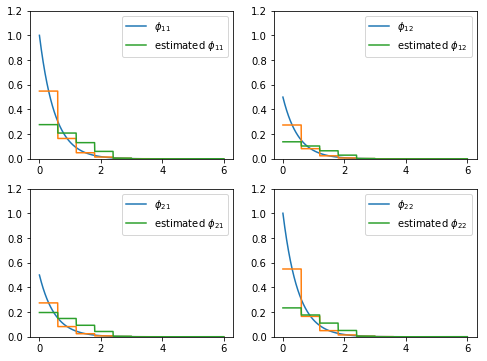

In [426]:
plt.figure(1,figsize=(8,6))
axs=plt.subplot(221)
axs.plot(np.linspace(0,6,100),1*np.exp(-2*np.linspace(0,6,100)),label='$\phi_{11}$')
axs.plot(np.linspace(0,6,1000,endpoint=False),[1*np.exp(-2*np.linspace(T_phi/len(g_tau[0])/2,T_phi-T_phi/len(g_tau[0])/2,len(g_tau[0])))[int(xx/(T_phi/len(g_tau[0])))] for xx in np.linspace(0,6,1000,endpoint=False)])
axs.plot(np.linspace(0,6,1000,endpoint=False),[a_final[0][0][0]*g_tau_final[0][int(xx/(T_phi/len(g_tau_final[0])))] for xx in np.linspace(0,6,1000,endpoint=False)],label='estimated $\phi_{11}$')
plt.ylim(0,1.2)
plt.legend()
axs=plt.subplot(222)
axs.plot(np.linspace(0,6,100),0.5*np.exp(-2*np.linspace(0,6,100)),label='$\phi_{12}$')
axs.plot(np.linspace(0,6,1000,endpoint=False),[0.5*np.exp(-2*np.linspace(T_phi/len(g_tau[0])/2,T_phi-T_phi/len(g_tau[0])/2,len(g_tau[0])))[int(xx/(T_phi/len(g_tau[0])))] for xx in np.linspace(0,6,1000,endpoint=False)])
axs.plot(np.linspace(0,6,1000,endpoint=False),[a_final[0][1][0]*g_tau_final[0][int(xx/(T_phi/len(g_tau_final[0])))] for xx in np.linspace(0,6,1000,endpoint=False)],label='estimated $\phi_{12}$')
plt.ylim(0,1.2)
plt.legend()
axs=plt.subplot(223)
axs.plot(np.linspace(0,6,100),0.5*np.exp(-2*np.linspace(0,6,100)),label='$\phi_{21}$')
axs.plot(np.linspace(0,6,1000,endpoint=False),[0.5*np.exp(-2*np.linspace(T_phi/len(g_tau[0])/2,T_phi-T_phi/len(g_tau[0])/2,len(g_tau[0])))[int(xx/(T_phi/len(g_tau[0])))] for xx in np.linspace(0,6,1000,endpoint=False)])
axs.plot(np.linspace(0,6,1000,endpoint=False),[a_final[1][0][0]*g_tau_final[0][int(xx/(T_phi/len(g_tau_final[0])))] for xx in np.linspace(0,6,1000,endpoint=False)],label='estimated $\phi_{21}$')
plt.ylim(0,1.2)
plt.legend()
axs=plt.subplot(224)
axs.plot(np.linspace(0,6,100),1*np.exp(-2*np.linspace(0,6,100)),label='$\phi_{22}$')
axs.plot(np.linspace(0,6,1000,endpoint=False),[1*np.exp(-2*np.linspace(T_phi/len(g_tau[0])/2,T_phi-T_phi/len(g_tau[0])/2,len(g_tau[0])))[int(xx/(T_phi/len(g_tau[0])))] for xx in np.linspace(0,6,1000,endpoint=False)])
axs.plot(np.linspace(0,6,1000,endpoint=False),[a_final[1][1][0]*g_tau_final[0][int(xx/(T_phi/len(g_tau_final[0])))] for xx in np.linspace(0,6,1000,endpoint=False)],label='estimated $\phi_{22}$')
plt.ylim(0,1.2)
plt.legend()
plt.show()